## 1: Derivative Operator for Simple Functions constructed out of sin,cos (Example from last time)
### Recap

Consider the hacker example of the previous paper where we considered functions constructed out of the basis $\{sin,cos\}$
$$
u(x)=p_{sin}\cdot sin(x) + p_{cos}\cdot cos(x) \in U
$$
with the main goal of computing its derivative which lies in the same space spanned by the basis above, but which for distinguishability we call $V$:
$$
v(x)=q_{sin}\cdot sin(x) + q_{cos}\cdot cos(x) \in V
$$

The encoder was programmed by applying the $scipy.curve\_fit()$ method to $u(x)$ in order to obtain the coefficients $p_{sin},p_{cos}$. Then a linear layer NN $\varphi$ was applied to obtain $q_{sin},q_{cos}$ and this was decoded by plugging the coefficients into the basis expansion.

The use of a linear layer and the generation of training data was justified by the already known analytical solution for $\varphi$ which in matrix form could be written as:
$$
\varphi = 
\begin{bmatrix}
0& -1\\
1 & 0
\end{bmatrix}
$$

In [15]:
#Import the necessary modules
import torch
import torch.nn as nn
import torch.nn.functional as F #Includes the activation functions

import math
import matplotlib.pyplot as plt 
import numpy as np

torch.manual_seed(0) #for reproducible results

tensor([[0.0467]])   tensor([[0.6073]])
Epoch 1 | MSE Loss = 1.1310946941375732
Epoch 201 | MSE Loss = 0.06580333411693573
Epoch 401 | MSE Loss = 0.041901979595422745
Epoch 601 | MSE Loss = 0.024463657289743423
Epoch 801 | MSE Loss = 0.007939593866467476
Epoch 1001 | MSE Loss = 0.005157225299626589
Epoch 1201 | MSE Loss = 0.008669368922710419
Epoch 1401 | MSE Loss = 0.0024852680508047342
Epoch 1601 | MSE Loss = 0.003940195310860872
Epoch 1801 | MSE Loss = 0.004333436023443937


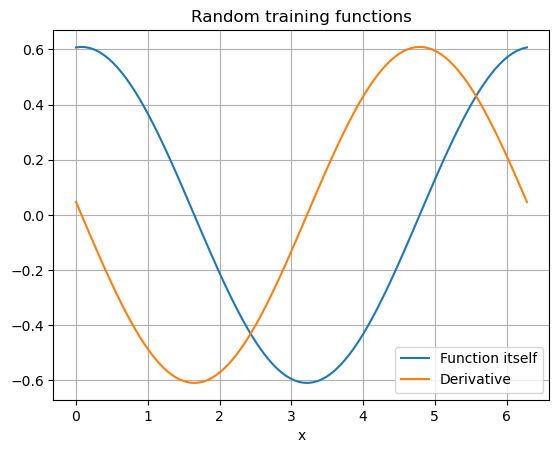

In [16]:
#Define branch net
class BranchNet(nn.Module):
    def __init__(self,m_dim,p_dim,depth=3):
        super().__init__()
        layers = [nn.Linear(m_dim,p_dim),nn.Tanh()] #First linear layer with tanh activation function m_dim-> p_dim
        for _ in range(depth-1):
            layers += [nn.Linear(p_dim,p_dim),nn.Tanh()] #Hidden layers with tanh activation function p_dim->p_dim
        self.net = nn.Sequential(*layers)
    def forward(self,func_at_sensors):
        return self.net(func_at_sensors)

#Define trunk net
class TrunkNet(nn.Module):
    def __init__(self,p_dim,depth=3):
        super().__init__()
        layers = [nn.Linear(1,p_dim),nn.Tanh()] #First linear layer with tanh activation function 1-> p_dim
        for _ in range(depth-1):
            layers += [nn.Linear(p_dim,p_dim),nn.Tanh()] #Hidden layers with tanh activation function 1->p_dim
        self.net = nn.Sequential(*layers)
    def forward(self,y):
        return self.net(y)
        

#Define DeepONet as a combination of branch and trunk net
class DeepONet(nn.Module):
    def __init__(self,m_dim,p_dim):
        super().__init__()
        self.branch = BranchNet(m_dim,p_dim)
        self.trunk = TrunkNet(p_dim)
    def forward(self,func_at_sensors,y):
        b = self.branch(func_at_sensors) #(batchsize,p_dim)
        t = self.trunk(y) #(batchsize,p_dim)
        return torch.sum(b*t,dim=1,keepdim=True) #b*t elementwise multiplication: (batchsize,p_dim); then torch.sum(..,dim=1) sums across the feature dim.; keepdim keeps the summed dim. as 1 -> (batchsize,1) -> loss functions expect this format

#Training
sensor_points_num = 100 #How many sensor points to consider
eval_num = 200 #How many y-points to consider
p_dim = 100 #Latent dimensionality
model = DeepONet(sensor_points_num,p_dim)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss_MSE = torch.nn.MSELoss()
sensor_points = torch.linspace(0,2*math.pi,sensor_points_num) #create equidistant sensor points
y = torch.linspace(0,2*math.pi,eval_num)

def generate_random_funcs(func_num): #func_num=how many functions to generate
    p_sin = torch.randn(func_num,1) #sample from standard normal: shape (func_num,1)
    p_cos = torch.randn(func_num,1)
    f = p_sin*torch.sin(sensor_points)[None,:] + p_cos*torch.cos(sensor_points)[None,:] #[None,:] adds batch dimension -> (1,m) -> f is (func_num,m)
    return f,p_sin,p_cos

def derivative_funcs(p_sin,p_cos):
    Phi = torch.tensor([[0.0,-1.0],[1.0,0.0]]) #Known matrix for our problem
    v = torch.cat([p_sin,p_cos],dim=1).T #obtain v of shape (2, func_num)
    result = torch.matmul(Phi,v) #result (2,func_num)
    f_der = result[0][:,None]*torch.sin(sensor_points)[None,:] + result[1][:,None]*torch.cos(sensor_points)[None,:]
    return f_der,result[0][:,None],result[1][:,None]

#Sanity check
f,a,b = generate_random_funcs(1)
f_der,a_der,b_der = derivative_funcs(a,b)
print(a," ",b)
plt.plot(sensor_points,f.squeeze(),label="Function itself") #squeeze removes all dimensions from size 1
plt.plot(sensor_points,f_der.squeeze(),label="Derivative")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions")
plt.legend()

func_num = 1000 #How many training functions to consider
funcs,p_sin_a,p_cos_a = generate_random_funcs(func_num)
funcs_deriv,da,db = derivative_funcs(p_sin_a,p_cos_a)

for epoch in range(2000):
    #To solve dim. problem divide into batches
    batch_size = 256

    # Randomly sample function indices and point indices
    func_id = torch.randint(0, func_num, (batch_size,)) 
    y_id    = torch.randint(0, sensor_points_num, (batch_size,))
    f_batch = funcs[func_id] 
    y_batch = sensor_points[y_id].unsqueeze(1)

    # Get the true derivative at those coordinates
    label = funcs_deriv[func_id, y_id].unsqueeze(1)

    predicted = model(f_batch,y_batch)
    loss = loss_MSE(predicted,label)
    loss.backward()#Does backpropagation
    optimizer.step() #Updates weights and biases
    optimizer.zero_grad() #Set all gradients to zero for next iterations, as torch saves them by default
    if epoch % 200 == 0:
        print("Epoch {0} | MSE Loss = {1}".format(epoch+1,loss))


tensor([[-0.9781]])   tensor([[-1.1523]])


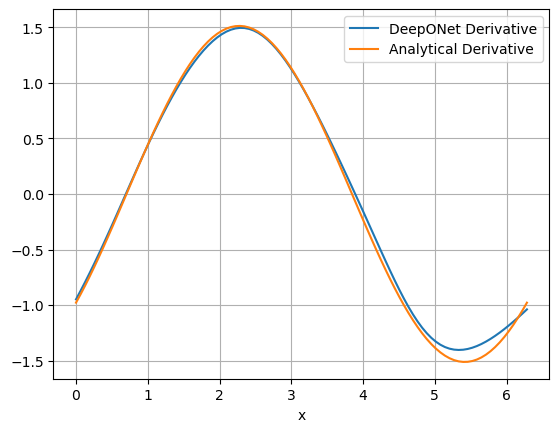

In [17]:
#Inference: Test the model for a function
f,a,b = generate_random_funcs(1)
f_model = model(f.repeat(100,1),sensor_points.unsqueeze(1))
f_der,a_der,b_der = derivative_funcs(a,b)
print(a," ",b)
plt.plot(sensor_points,f_model.detach().squeeze(),label="DeepONet Derivative")
plt.plot(sensor_points,f_der.squeeze(),label="Analytical Derivative")
plt.grid()
plt.xlabel("x")
plt.legend()